# Image Matching

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
import cv2
import imutils
import glob
import os
from itertools import accumulate
import sys
sys.path.append('/home/tung/playground/delf_instance_retrieval/delf/delf/python/examples/')
from utils import download_and_resize_image, resize_image, show_images, image_input_fn, match_images

np.random.seed(10)

In [ ]:
#!pip install scikit-image
#!pip install tensorflow-hub
#!pip install opencv-python
#!pip install imutils

## Match an image pair

In [10]:
#IMAGE_1_URL = 'https://images.unsplash.com/photo-1522184808165-a39a75502037?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=9058a9f269234b4d7b6dc7bd7066d7e8&auto=format&fit=crop&w=1350&q=80'
#IMAGE_2_URL = 'https://images.unsplash.com/photo-1479660656269-197ebb83b540?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=88b85498e4c076fce0ed0c086543afb6&auto=format&fit=crop&w=1952&q=80'

IMAGE_1_JPG = '3_1.jpg'
IMAGE_2_JPG = '3_2.jpg'

IMAGE_1_URL = '../images/' + IMAGE_1_JPG
IMAGE_2_URL = '../images/' + IMAGE_2_JPG

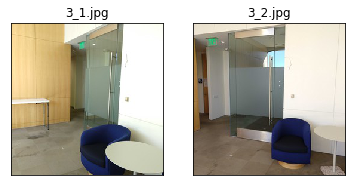

In [12]:
#resize_image(IMAGE_1_URL, IMAGE_1_JPG)
#resize_image(IMAGE_2_URL, IMAGE_2_JPG)
download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

In [13]:
# load delf model


tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

# load model
m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder, # Image tensor with dtype float32 and shape [height, width, 3]
    'score_threshold': 100.0, # Image features whose attention score exceeds this threshold will be returned
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000, # The maximum number of features that should be returned
}

# Apply the DELF module to the inputs to get the outputs.
module_outputs = m(module_inputs, as_dict=True)

In [14]:
image_tf = image_input_fn([IMAGE_1_JPG, IMAGE_2_JPG])

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

# delf_outputs is a dictionary of named tensors:
# * delf_outputs['locations']: a Tensor with dtype float32 and shape [None, 2],
#   where each entry is a coordinate (vertical-offset, horizontal-offset) in
#   pixels from the top-left corner of the image.
# * delf_outputs['descriptors']: a Tensor with dtype float32 and shape
#   [None, 40], where delf_outputs['descriptors'][i] is a 40-dimensional
#   descriptor for the image at location delf_outputs['locations'][i].

Extracting locations and descriptors from 3_1.jpg
Extracting locations and descriptors from 3_2.jpg


Loaded image 1's 89 features
Loaded image 2's 85 features


/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:683: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python3.6/dist-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


Found 20 inliers


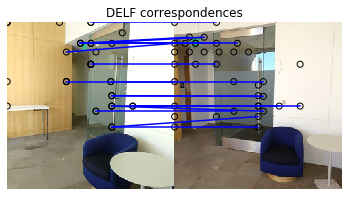

In [15]:
match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)

## Match a query to the database

In [ ]:
import csv
import codecs
building_descs = []
f = codecs.open('./images/buildings.csv', 'rU', encoding='utf-8-sig')
reader = csv.reader(f)
for utf8_row in reader:
    building_descs.append(utf8_row[0])
building_descs

### Resize all database images

In [72]:
def resize_image(srcfile, destfile, new_width=256, new_height=256):
    pil_image = Image.open(srcfile)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(destfile, format='JPEG', quality=90)
    return destfile
def resize_images_folder(srcfolder, destfolder='../images/resized', new_width=256, new_height=256):
    os.makedirs(destfolder,exist_ok=True)
    for srcfile in glob.iglob(os.path.join('/home/tung/playground/data/InLoc/database_cutouts_imageonly/DUC1/*', '*.[Jj][Pp][Gg]')):
        src_basename = os.path.basename(srcfile)
        destfile=os.path.join(destfolder,src_basename)
        resize_image(srcfile, destfile, new_width, new_height)
    return destfolder
def get_resized_db_image_paths(destfolder='/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized'):
    return sorted(list(glob.iglob(os.path.join(destfolder, '*.[Jj][Pp][Gg]'))))

In [73]:
#resize_images_folder('../images/oxford5k_images')
resize_images_folder('../images/InLoc/database_cutouts_imageonly/DUC1')

'../images/resized'

In [74]:
db_images = get_resized_db_image_paths()
db_images

['/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_0_-30.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_0_0.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_0_30.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_120_-30.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_120_0.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_120_30.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_150_-30.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_150_0.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_150_30.jpg',
 '/home/tung/playground/data/InLoc/database_cutouts_imageonly

In [75]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn(db_images)

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in db_images:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_000_150_-30.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_001_330_30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_003_270_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_005_150_-30.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_006_330_0.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_008_240_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_009_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_009_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_009_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_010_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_010_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_010_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_010_120_-30.jpg
Extract

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_011_330_0.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_013_210_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_014_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_014_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_014_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_014_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_015_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_015_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_015_0_30.jpg
Extractin

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_016_30_30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_018_240_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_019_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_019_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_019_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_020_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_020_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_020_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_020_120_-30.jpg
Extract

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_021_330_-30.jpg
E

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_023_210_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_024_90_30.jpg
Extra

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_027_300_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_029_180_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_030_90_-30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_032_270_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_034_150_0.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_035_60_30.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_037_270_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_038_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_038_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_039_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_039_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_039_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_039_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_039_120_0.jpg
Extracti

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_040_330_-30.jpg
E

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_042_210_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_043_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_043_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_043_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_043_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_043_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_043_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_044_0_-30.jpg
Extrac

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_045_300_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_047_180_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_048_90_0.jpg
Extra

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_050_300_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_052_180_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_053_90_0.jpg
Extra

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_055_270_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_057_150_30.jpg
E

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_058_60_30.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_060_270_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_062_150_0.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_063_60_-30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_065_270_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_068_150_0.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_069_330_30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_071_240_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_072_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_073_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_073_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_073_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_073_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_073_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_073_120_30.jpg
Extrac

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_074_330_0.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_076_240_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_077_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_077_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_077_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_077_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_078_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_078_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_078_0_30.jpg
Extractin

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_079_30_-30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_081_210_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_082_90_30.jpg
Extra

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_084_300_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_086_180_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_087_90_30.jpg
Extra

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_089_30_-30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_091_180_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_092_60_30.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_094_270_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_096_150_-30.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_097_330_0.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_099_240_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_100_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_100_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_101_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_101_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_101_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_101_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_101_120_0.jpg
Extracti

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_102_330_0.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_104_240_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_105_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_105_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_106_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_106_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_106_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_106_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_106_120_0.jpg
Extracti

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_107_330_0.jpg
Ext

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_110_240_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_111_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_111_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_111_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_111_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_112_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_112_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_112_0_30.jpg
Extractin

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_113_30_30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_115_240_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_116_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_116_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_116_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_116_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_117_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_117_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_117_0_30.jpg
Extractin

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_118_330_-30.jpg
E

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_180_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_180_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_210_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_210_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_120_240_-30.jp

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_121_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_121_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_121_90_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_121_90_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_121_90_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_122_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_122_0_0.jpg
Extractin

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_270_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_300_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_300_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_300_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_123_30_-30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_150_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_150_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_150_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_180_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_125_180_0.jpg


Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_60_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_60_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_60_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_126_90_-30.jpg
Ex

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_210_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_240_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_240_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_240_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_270_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_270_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_128_270_30.jpg

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_0_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_0_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_0_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_120_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_120_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_120_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_130_150_-30.jpg
Extr

Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_30_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_30_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_30_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_330_-30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_330_0.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_330_30.jpg
Extracting locations and descriptors from /home/tung/playground/data/InLoc/database_cutouts_imageonly/images/resized/DUC_cutout_131_60_-30.jpg
Ex

In [76]:
def compute_locations_and_descriptors(image_path):
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://tfhub.dev/google/delf/1')

    # The module operates on a single image at a time, so define a placeholder to
    # feed an arbitrary image in.
    image_placeholder = tf.placeholder(
        tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    image_tf = image_input_fn([image_path])

    with tf.train.MonitoredSession() as sess:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        return sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

### Aggregate all database images' locations and descriptors to lists
Calculate accumulated/aggregated indexes boundaries per image so we can reverse search the image index given an accumulated/aggregated index.

In [77]:
locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))

### Build KD tree with database images' descriptors

In [78]:
d_tree = cKDTree(descriptors_agg) # build the KD tree

## Query a new image

In [84]:
query_image = '/home/tung/playground/delf_instance_retrieval/delf/delf/python/examples/images/IMG_0818.JPG'
def preprocess_query_image(imagepath):
    '''
    Resize the query image and return the resized image path.
    '''
    query_temp_folder_name = 'query_temp_folder'
    query_temp_folder = os.path.join(os.path.dirname(query_image), query_temp_folder_name)
    os.makedirs(query_temp_folder,exist_ok=True)
    query_basename = os.path.basename(query_image)
    destfile=os.path.join(query_temp_folder,query_basename)
    resized_image = resize_image(query_image, destfile)
    return resized_image

resized_image = preprocess_query_image(query_image)

In [85]:
query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)

Extracting locations and descriptors from /home/tung/playground/delf_instance_retrieval/delf/delf/python/examples/images/query_temp_folder/IMG_0818.JPG


### Query the KD tree to find K nearest neighbors for each descriptor

In [86]:
distance_threshold = 0.8
# K nearest neighbors
K = 10
distances, indices = d_tree.query(
    query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

# Find the list of unique accumulated/aggregated indexes
unique_indices = np.array(list(set(indices.flatten())))

unique_indices.sort()
if unique_indices[-1] == descriptors_agg.shape[0]:
    unique_indices = unique_indices[:-1]

## Get a list of database candidate image indexes
Look up a list of unique image indexes, each image contains at least one of K nearest neighbor result descriptors.
By reverse indexes look up.

In [87]:
unique_image_indexes = np.array(
    list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
              for index in unique_indices])))
unique_image_indexes

array([   3,  516,  517,    6,    7, 1030, 1033, 1543,   11,  523,  525,
        526, 1039, 1546, 3084, 1530, 1043, 3600,   21, 1045, 1531, 3610,
         27,   28, 2041,  544, 1057,   34, 1570,   36,   37, 1060,  551,
         40,  553,   42,   43, 1061, 1063,  558, 1072,  561,  562, 4589,
       1588, 3637,   55,  568,  569,  571,   60,  574,   70,  583, 4480,
       3149,   79,   81,   85,   88,   89,   90,   91,   92,   93,   94,
        601,  607, 2142, 2143,   99,  100, 1123,  102, 1126, 2662, 3479,
       3682, 4198, 4601, 2566,  113,  115,  118,  122, 2682, 3077,  637,
       3706, 2176, 1153, 1156,  133, 2181, 3716,  137, 3721,  139,  651,
        652,  142, 1164, 1170, 1172, 1174, 1175,  154,  667,  668, 1179,
       1180, 1693, 1184, 1696, 1697,  679, 1192, 1193,  682,  171,  683,
        684, 2042, 3239, 2224, 3752, 4484, 1203, 1204,  181, 1207,  186,
       1210,  188, 3259, 3262,  707, 1733,  198,  201, 3274, 1739,  721,
       2258, 1747, 3794, 3797,  731,  738, 2787, 27

In [70]:
def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
    '''
    Image index to accumulated/aggregated locations/descriptors pair indexes.
    '''
    if index > len(accumulated_indexes_boundaries) - 1:
        return None
    accumulated_index_start = None
    accumulated_index_end = None
    if index == 0:
        accumulated_index_start = 0
        accumulated_index_end = accumulated_indexes_boundaries[index]
    else:
        accumulated_index_start = accumulated_indexes_boundaries[index-1]
        accumulated_index_end = accumulated_indexes_boundaries[index]
    return np.arange(accumulated_index_start,accumulated_index_end)

In [64]:
def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries):
    '''
    Get a pair of locations to use, the query image to the database image with given index.
    Return: a tuple of 2 numpy arrays, the locations pair.
    '''
    image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
    locations_2_use_query = []
    locations_2_use_db = []
    for i, row in enumerate(k_nearest_indices):
        for acc_index in row:
            if acc_index in image_accumulated_indexes:
                locations_2_use_query.append(query_image_locations[i])
                locations_2_use_db.append(locations_agg[acc_index])
                break
    return np.array(locations_2_use_query), np.array(locations_2_use_db)
            

### Perform geometric verification using RANSAC and visualization

Found inliers for image 525 -> 2


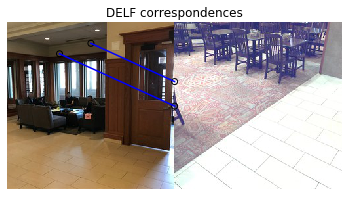

Found inliers for image 526 -> 3


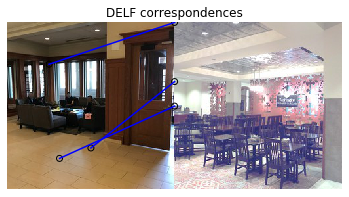

Found inliers for image 1546 -> 2


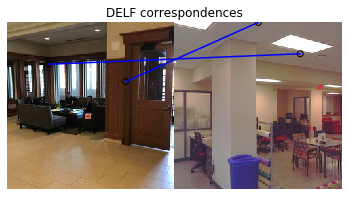

Found inliers for image 1045 -> 3


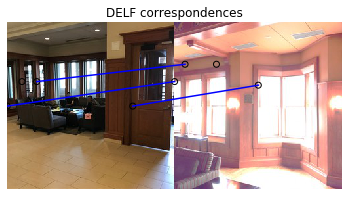

Found inliers for image 544 -> 2


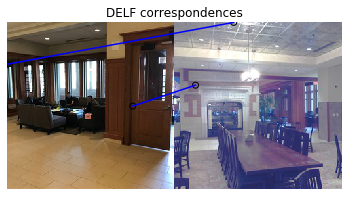

Found inliers for image 1057 -> 2


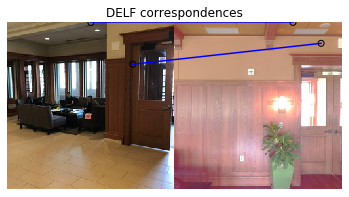

Found inliers for image 1060 -> 4


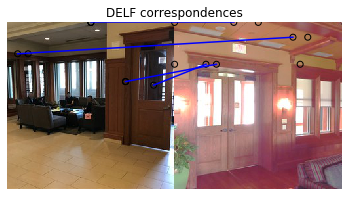

Found inliers for image 40 -> 2


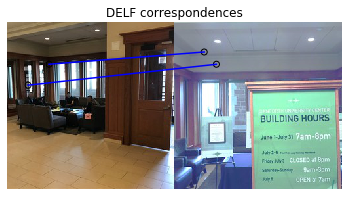

Found inliers for image 42 -> 2


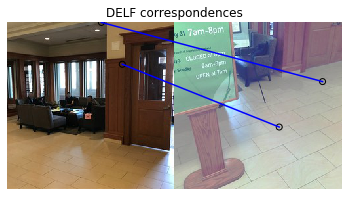

Found inliers for image 43 -> 2


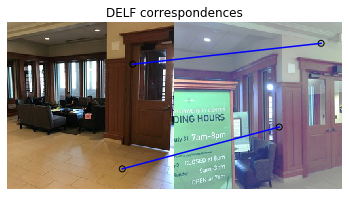

Found inliers for image 1063 -> 2


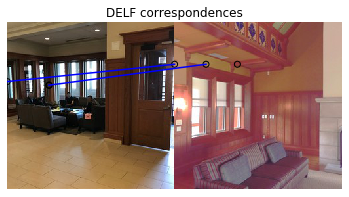

Found inliers for image 562 -> 2


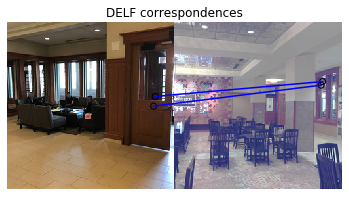

Found inliers for image 55 -> 2


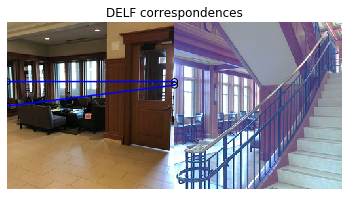

Found inliers for image 574 -> 3


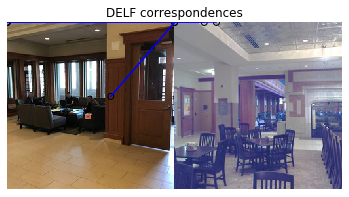

Found inliers for image 70 -> 5


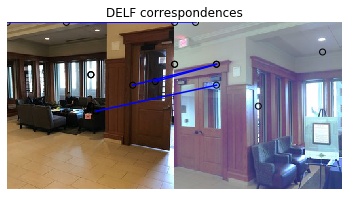

Found inliers for image 4480 -> 1


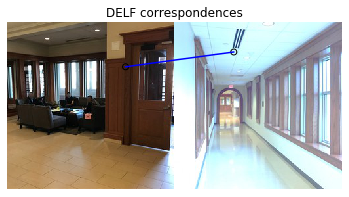

Found inliers for image 88 -> 4


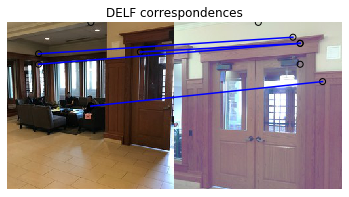

Found inliers for image 89 -> 4


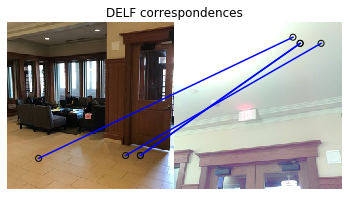

Found inliers for image 91 -> 4


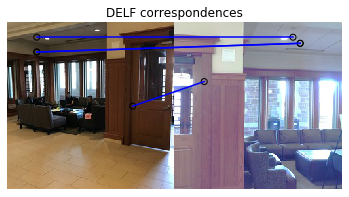

Found inliers for image 94 -> 7


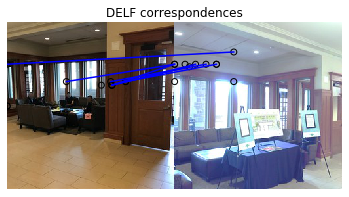

Found inliers for image 607 -> 3


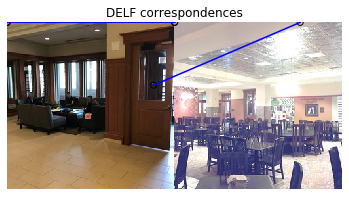

Found inliers for image 100 -> 3


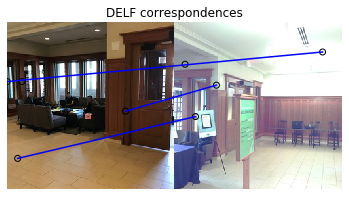

Found inliers for image 1126 -> 2


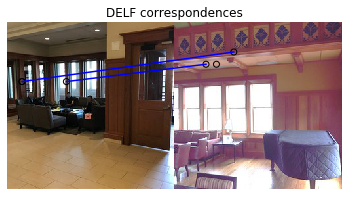

Found inliers for image 3682 -> 2


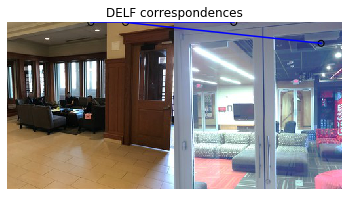

Found inliers for image 122 -> 2


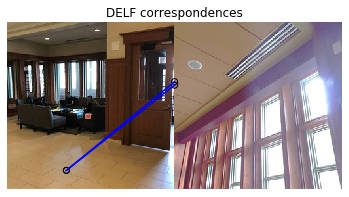

Found inliers for image 133 -> 2


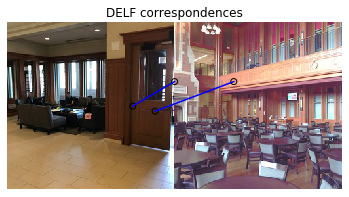

Found inliers for image 139 -> 4


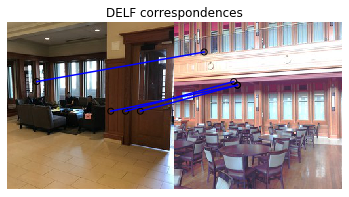

Found inliers for image 142 -> 3


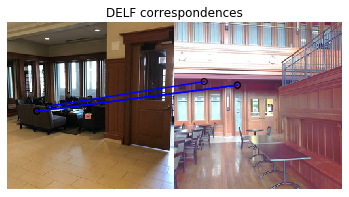

Found inliers for image 1174 -> 2


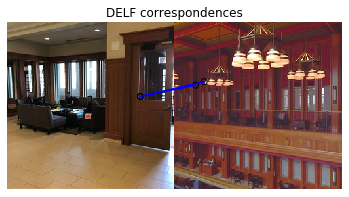

Found inliers for image 1179 -> 2


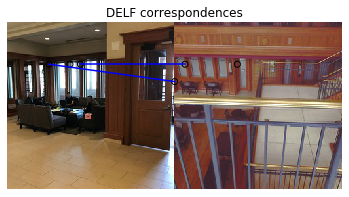

Found inliers for image 1180 -> 3


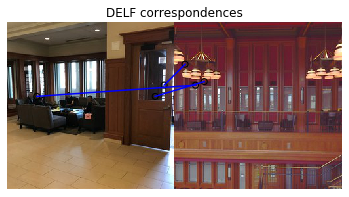

Found inliers for image 682 -> 3


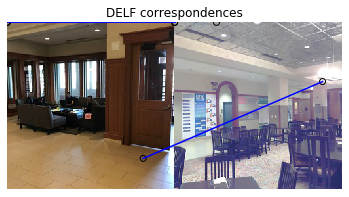

Found inliers for image 4484 -> 1


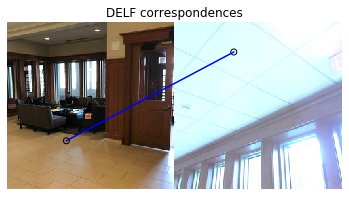

Found inliers for image 1207 -> 4


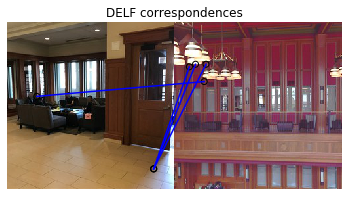

Found inliers for image 1210 -> 5


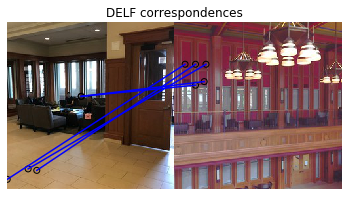

Found inliers for image 3262 -> 2


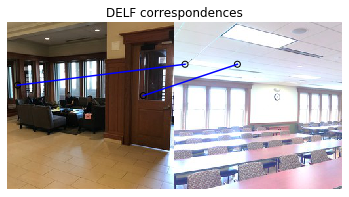

Found inliers for image 707 -> 2


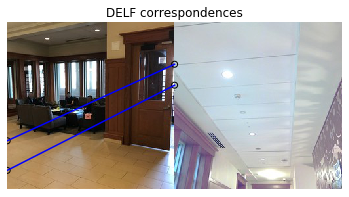

Found inliers for image 2281 -> 2


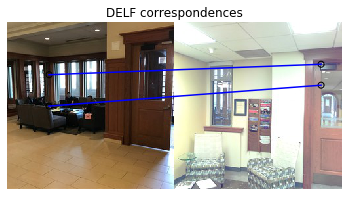

LinAlgError: Arrays cannot be empty

In [88]:
# Array to keep track of all candidates in database.
inliers_counts = []
# Read the resized query image for plotting.
img_1 = mpimg.imread(resized_image)
for index in unique_image_indexes:
    locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
    # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_2_use_db, locations_2_use_query), # source and destination coordinates
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    # If no inlier is found for a database candidate image, we continue on to the next one.
    if inliers is None or len(inliers) == 0:
        continue
    # the number of inliers as the score for retrieved images.
    inliers_counts.append({"index": index, "inliers": sum(inliers)})
    print('Found inliers for image {} -> {}'.format(index, sum(inliers)))
    # Visualize correspondences.
    _, ax = plt.subplots()
    img_2 = mpimg.imread(db_images[index])
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_2_use_db,
        locations_2_use_query,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

In [89]:
inliers_counts

[{'index': 525, 'inliers': 2},
 {'index': 526, 'inliers': 3},
 {'index': 1546, 'inliers': 2},
 {'index': 1045, 'inliers': 3},
 {'index': 544, 'inliers': 2},
 {'index': 1057, 'inliers': 2},
 {'index': 1060, 'inliers': 4},
 {'index': 40, 'inliers': 2},
 {'index': 42, 'inliers': 2},
 {'index': 43, 'inliers': 2},
 {'index': 1063, 'inliers': 2},
 {'index': 562, 'inliers': 2},
 {'index': 55, 'inliers': 2},
 {'index': 574, 'inliers': 3},
 {'index': 70, 'inliers': 5},
 {'index': 4480, 'inliers': 1},
 {'index': 88, 'inliers': 4},
 {'index': 89, 'inliers': 4},
 {'index': 91, 'inliers': 4},
 {'index': 94, 'inliers': 7},
 {'index': 607, 'inliers': 3},
 {'index': 100, 'inliers': 3},
 {'index': 1126, 'inliers': 2},
 {'index': 3682, 'inliers': 2},
 {'index': 122, 'inliers': 2},
 {'index': 133, 'inliers': 2},
 {'index': 139, 'inliers': 4},
 {'index': 142, 'inliers': 3},
 {'index': 1174, 'inliers': 2},
 {'index': 1179, 'inliers': 2},
 {'index': 1180, 'inliers': 3},
 {'index': 682, 'inliers': 3},
 {'ind

### Show the top match result
Employ the number of inliers as the score for retrieved images.

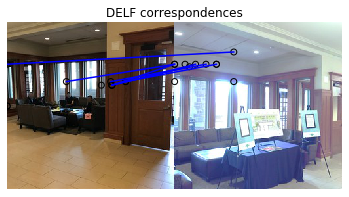

In [90]:
top_match = sorted(inliers_counts, key=lambda k: k['inliers'], reverse=True)[0]

index = top_match['index']
#print('Best guess for this image:', building_descs[index])
locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
# Perform geometric verification using RANSAC.
_, inliers = ransac(
    (locations_2_use_db, locations_2_use_query), # source and destination coordinates
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)
# Visualize correspondences.
_, ax = plt.subplots()
img_2 = mpimg.imread(db_images[index])
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
    ax,
    img_1,
    img_2,
    locations_2_use_db,
    locations_2_use_query,
    np.column_stack((inlier_idxs, inlier_idxs)),
    matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(np.unique(locations_agg, axis=0), columns=['x', 'y'])
df.head()

In [ ]:
fig, axe = plt.subplots(ncols=1, figsize = (6,6))
df.plot.scatter(x = 'x', y='y', fontsize=15, ax = axe)
axe.set_ylabel("y", size = 20)
axe.set_xlabel("x", size = 20)
plt.show()

In [ ]:
np.array(accumulated_indexes_boundaries)